<a href="https://colab.research.google.com/github/flistz/DASC-6510-Term-Project/blob/main/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_7dk611/qyk68gya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_7dk611/4pemd5bx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31029', 'data', 'file=/tmp/tmpc_7dk611/qyk68gya.json', 'init=/tmp/tmpc_7dk611/4pemd5bx.json', 'output', 'file=/tmp/tmpc_7dk611/prophet_model2bac4qag/prophet_model-20231201044329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:43:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:43:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


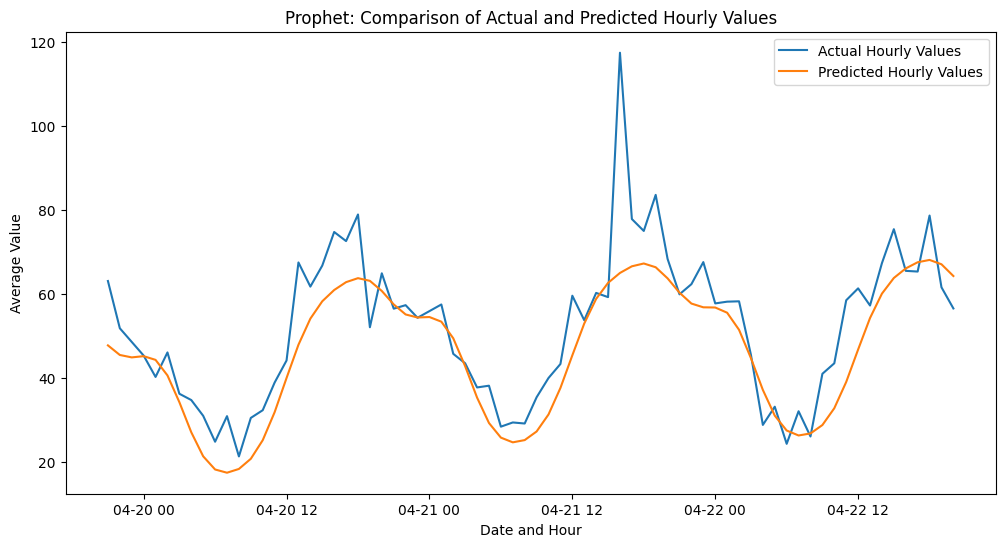

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

file_path = 'Twitter_volume_AMZN (1).csv'
df = pd.read_csv(file_path)

df_prophet = df.rename(columns={'timestamp': 'ds', 'value': 'y'})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['hour'] = df_prophet['ds'].dt.floor('H')
hourly_data = df_prophet.groupby('hour')['y'].mean().reset_index()

hourly_data.rename(columns={'hour': 'ds', 'y': 'y'}, inplace=True)

hours = 72
train_hourly = hourly_data.iloc[:-hours]
test_hourly = hourly_data.iloc[-hours:]

model_hourly = Prophet()
model_hourly.fit(train_hourly)

future_hourly = model_hourly.make_future_dataframe(periods=hours, freq='H')

forecast_hourly = model_hourly.predict(future_hourly)

predicted_hourly = forecast_hourly[-hours:]
lower_bound = predicted_hourly['yhat_lower']
upper_bound = predicted_hourly['yhat_upper']

plt.figure(figsize=(12, 6))
plt.plot(test_hourly['ds'], test_hourly['y'], label='Actual Hourly Values')
plt.plot(predicted_hourly['ds'], predicted_hourly['yhat'], label='Predicted Hourly Values')
plt.title('Prophet: Comparison of Actual and Predicted Hourly Values')
plt.xlabel('Date and Hour')
plt.ylabel('Average Value')
plt.legend()
plt.show()

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss: 15.543886184692383
epoch: 25 loss: 3.856414794921875
epoch: 50 loss: 12.203741073608398
epoch: 75 loss: 2.8720412254333496
epoch: 100 loss: 2.080963373184204
epoch: 125 loss: 2.149378538131714
epoch: 150 loss: 1.569001317024231
epoch: 175 loss: 1.17747962474823
epoch: 200 loss: 0.9568135738372803
epoch: 225 loss: 0.7890530824661255
epoch: 250 loss: 0.6485722064971924
epoch: 275 loss: 0.5328993201255798
epoch: 300 loss: 0.43779295682907104
epoch: 325 loss: 0.3588089644908905
epoch: 350 loss: 0.29257407784461975
epoch: 375 loss: 0.2369047999382019
epoch: 400 loss: 0.18991713225841522
epoch: 425 loss: 0.15035498142242432
epoch: 450 loss: 0.11707818508148193
epoch: 475 loss: 0.08924353867769241
epoch: 500 loss: 0.06611762940883636
epoch: 525 loss: 0.04717306047677994
epoch: 550 loss: 0.03193623572587967
epoch: 575 loss: 0.020029401406645775


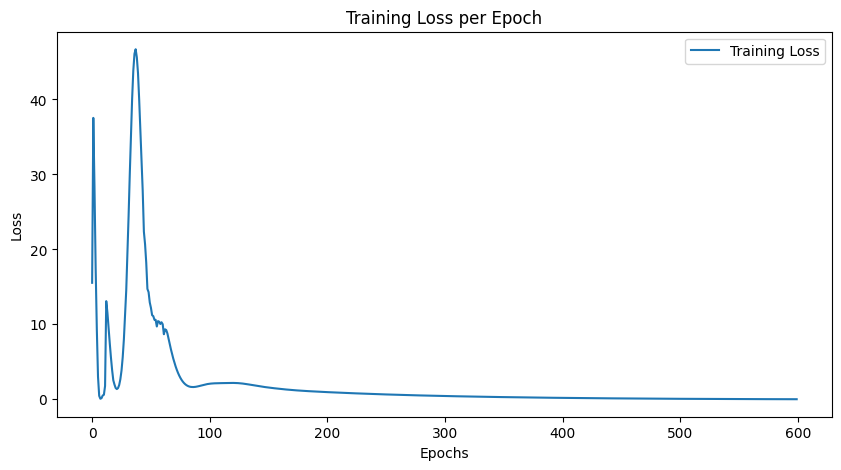

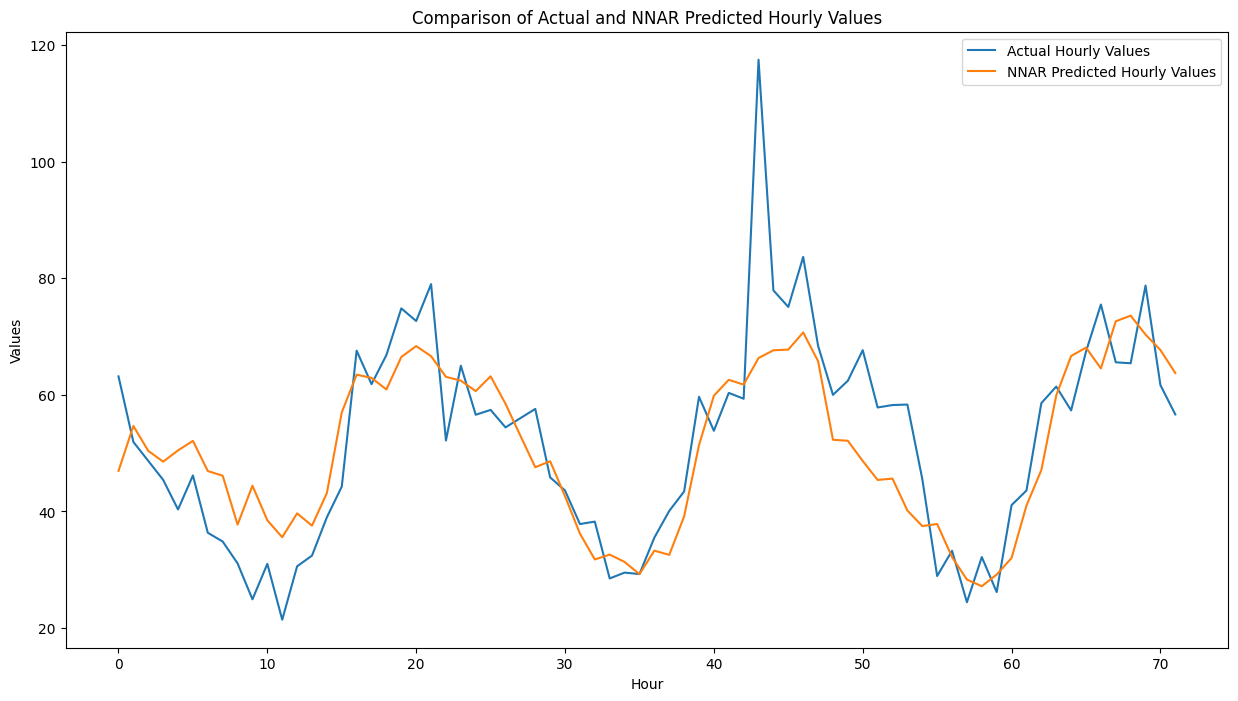

In [4]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

class NNAR(nn.Module):
    def __init__(self, input_size, hidden_layer_size=100, output_size=1):
        super(NNAR, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_window = 24 * 7

train_data_normalized = torch.FloatTensor(train_hourly['y'].values).to(device)
test_data_normalized = torch.FloatTensor(test_hourly['y'].values).to(device)

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

model = NNAR(input_size=train_window).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

epochs = 600

for epoch in range(epochs):
    for seq, labels in train_inout_seq:
        seq, labels = Variable(seq).to(device), Variable(labels).to(device)
        optimizer.zero_grad()

        seq = seq.view(-1, train_window)
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    losses.append(single_loss.item())

    if epoch % 25 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()

test_inputs = train_data_normalized[-train_window:].tolist()

predicted_nn_values = []

for _ in range(72):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
    with torch.no_grad():
        model_output = model(seq).item()
        test_inputs.append(model_output)
        predicted_nn_values.append(model_output)

predicted_nn_values = torch.tensor(predicted_nn_values).cpu().numpy()

plt.figure(figsize=(15, 8))
plt.plot(range(len(test_hourly)), test_hourly['y'], label='Actual Hourly Values')  # Move data to CPU
plt.plot(range(len(test_hourly)), predicted_nn_values, label='NNAR Predicted Hourly Values')
plt.title('Comparison of Actual and NNAR Predicted Hourly Values')
plt.xlabel('Hour')
plt.ylabel('Values')
plt.legend()
plt.show()

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_prophet = mean_absolute_error(test_hourly['y'], predicted_hourly['yhat'])
mae_nn = mean_absolute_error(test_hourly['y'], predicted_nn_values)

mse_prophet = mean_squared_error(test_hourly['y'], predicted_hourly['yhat'])
mse_nn = mean_squared_error(test_hourly['y'], predicted_nn_values)

rmse_prophet = np.sqrt(mse_prophet)
rmse_nn = np.sqrt(mse_nn)

mape_prophet = np.mean(np.abs((test_hourly['y'] - predicted_hourly['yhat']) / test_hourly['y'])) * 100
mape_nn = np.mean(np.abs((test_hourly['y'] - predicted_nn_values) / test_hourly['y'])) * 100

print(f"Prophet MAE: {mae_prophet}")
print(f"NNAR MAE: {mae_nn}")

print(f"Prophet MSE: {mse_prophet}")
print(f"NNAR MSE: {mse_nn}")

print(f"Prophet RMSE: {rmse_prophet}")
print(f"NNAR RMSE: {rmse_nn}")

print(f"Prophet MAPE: {mape_prophet}")
print(f"NNAR MAPE: {mape_nn}")


Prophet MAE: 7.206146426259331
NNAR MAE: 7.569057019069941
Prophet MSE: 103.91793044579582
NNAR MSE: 104.42946505483005
Prophet RMSE: 10.194014442102572
NNAR RMSE: 10.219073590831512
Prophet MAPE: 13.872843404140525
NNAR MAPE: 15.361248474152456
